<a id = "part3"></a>
## Анализ A/B-теста

Результаты A/B-теста описаны в файлах /datasets/orders.csv и /datasets/visitors.csv.

## Задача
Анализ A/B-теста.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

In [4]:
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

orders['date'] = orders['date'].astype('datetime64')
visitors['date'] = visitors['date'].astype('datetime64')
orders = orders.drop_duplicates()
visitors = visitors.drop_duplicates()

orders2 = orders.groupby(
    'visitorId', 
    as_index=False
).apply(lambda x: x.reset_index(drop = True)
       )


orders.info()
visitors.info()
orders2

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null datetime64[ns]
revenue          1197 non-null int64
group            1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 56.1+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null datetime64[ns]
group       62 non-null object
visitors    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.9+ KB


transactionId   visitorId       date  revenue group
0    0  900025958      5114589    2019-08-16  570      B   
1    0  1887336629     6958315    2019-08-04  1490     B   
2    0  3679129301     8300375    2019-08-01  10510    B   
     1  4293855558     8300375    2019-08-07  1790     A   
3    0  797272237      11685486   2019-08-23  6201     A   
...           ...           ...          ...   ...    ..   
1026 1  1216533772     4266935830 2019-08-29  78990    B   
1027 0  51443164       4278982564 2019-08-05  24744    A   
1028 0  2724331495     4279090005 2019-08-04  6716     B   
1029 0  3796325351     4281247801 2019-08-25  2640     B   
1030 0  836739159      4283872382 2019-08-22  3806     B   

[1197 rows x 5 columns]

<a id = "part3.1.1"></a>
### Вывод по предобработке данных
- приведены типы дат в двух таблицах
- обнаружены 1197-1030 = 167 пользователей, которые фигурируют в 2х группах одновременно. Однако, так как в таблице visits нет ID пользователей, убирать их смысла нет - во второй таблице они останутся. О данном факте необходимо сообщить сотрудникам, предоставившим данные, чтобы ошибка не повторялась впредь.

In [5]:
datesGroups = orders[['date','group']].drop_duplicates()

#агрегированные комулятивные данные по дням о заказах
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(
        orders['date'] <= x['date'], 
        orders['group'] == x['group']
    )].agg(
        {'date' : 'max',
         'group' : 'max',
         'transactionId' : pd.Series.nunique,
         'visitorId' : pd.Series.nunique,
         'revenue' : 'sum'}
    ), axis=1
).sort_values(by=['date','group'])

#агрегированные комулятивные данные по дням о посетителях
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(
        visitors['date'] <= x['date'], 
        visitors['group'] == x['group']
    )].agg(
        {'date' : 'max',
         'group' : 'max',
         'visitors' : 'sum'}
    ), axis=1
).sort_values(by=['date','group'])

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, 
    left_on=['date', 'group'], 
    right_on=['date', 'group']
)
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845
...,...,...,...,...,...,...
57,2019-08-29,B,596,544,5559398,17708
58,2019-08-30,A,545,493,4022970,18037
59,2019-08-30,B,620,567,5774631,18198
60,2019-08-31,A,557,503,4084803,18736


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


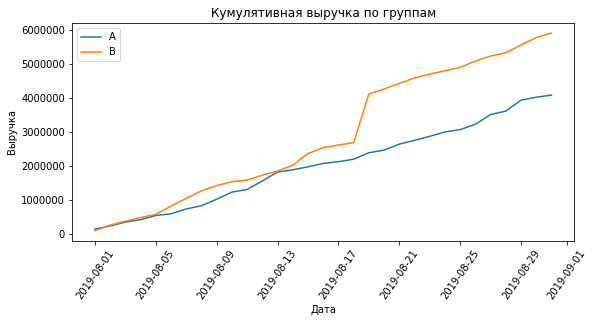

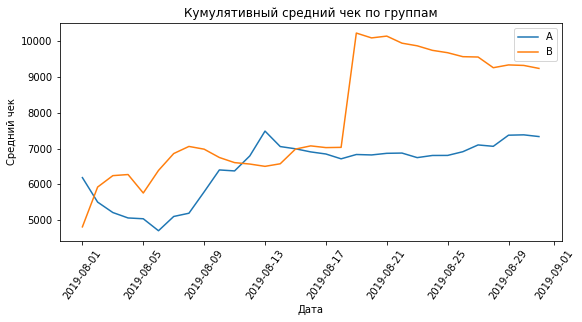

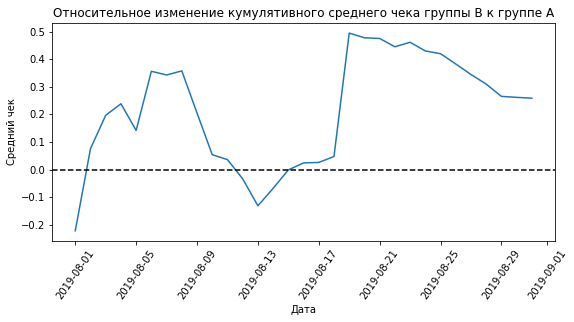

In [6]:
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][['date', 'revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][['date', 'revenue', 'orders']]


#выручка
plt.figure(figsize=(9,4))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('Кумулятивная выручка по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.xticks(rotation=55)

plt.legend()
plt.show()

#средний чек
plt.figure(figsize=(9,4))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('Кумулятивный средний чек по группам')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.xticks(rotation=55)
plt.legend()
plt.show()


mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, 
    left_on='date', 
    right_on='date', 
    how='left', 
    suffixes=['A', 'B']
)
plt.figure(figsize=(9,4))
plt.plot(mergedCumulativeRevenue['date'],(
    mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB']
)/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1
        )
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=55)
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.show()



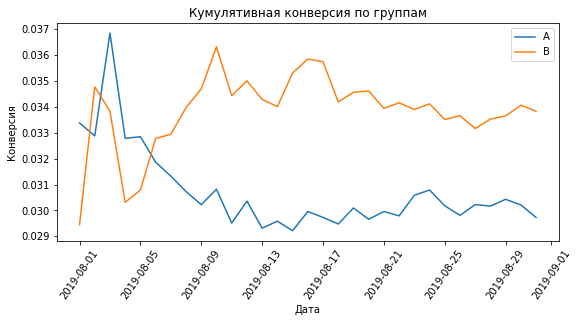

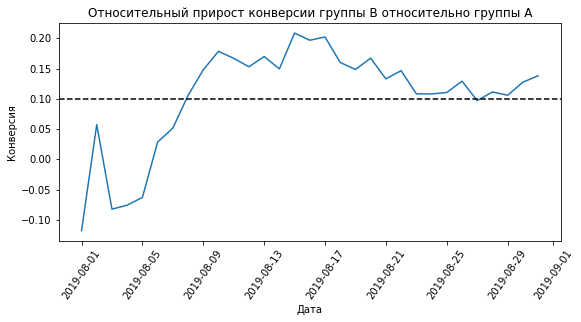

In [7]:
#конверсия
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']


plt.figure(figsize=(9,4))
plt.xticks(rotation=55)
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('Кумулятивная конверсия по группам')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.legend()
plt.show()

#относительное различие кумулятивных конверсий
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(
    cumulativeDataB[['date','conversion']], 
    left_on='date', 
    right_on='date', 
    how='left', 
    suffixes=['A', 'B'])
plt.figure(figsize=(9,4))
plt.xticks(rotation=55)
plt.plot(
    mergedCumulativeConversions['date'], 
    mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1
)
plt.title("Относительный прирост конверсии группы B относительно группы A")
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.axhline(y=0.1, color='black', linestyle='--')
plt.show()


<a id = "part3.1"></a>
### Вывод
- из графика кумулятивной выручки по группам видно, что выручка в группе В после некоторого времени превышает выручку в группе А, однако в группе В присутствует сильный вброс - очень дорогая покупка, которая значительно влияет на график. 
- из графика кумулятивного среднего чека по группам видно, что за время теста оба средних чека растут, в группе В присутсвует сильный выброс, затем средний чек группы В постепенно снижается, средний чек в группе А имеет тенденцию к росту.
- относительное изменение куммулятивного среднего чека группы В к А показывает скачки в нескольких точках, что свидетельствует об уже обнаруженных на предыдущих графиках вбросах - дорогих покупках.

- на графике кумулятивной конверсии по группам видно, что конверсия в группе В стабилизируется вокруг более высокого значения.
- это же видно на графике относительного прироста, кумулятивная конверсия в группе В на 10% и более выше, чем в группе А, показывает тенденцию к дальнейшему росту.

<a id = "part3.2"></a>
### Графики и персентили

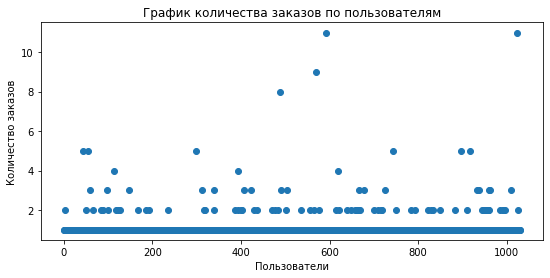

95-й и 99-й перцентили количества заказов на пользователя - [2. 4.]


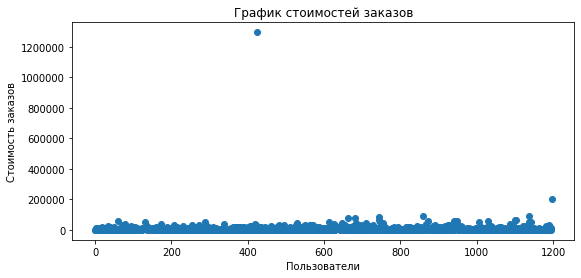

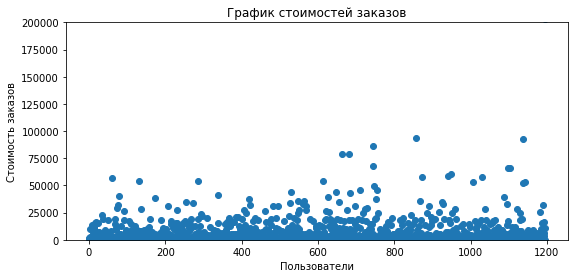

95-й и 99-й перцентили стоимости заказов - [28000.  58233.2]


In [8]:
#точечный график количества заказов по пользователям
ordersByUsers = (
    orders.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)

ordersByUsers.columns = ['userId', 'orders']
plt.figure(figsize=(9,4))
plt.title('График количества заказов по пользователям')
plt.xlabel('Пользователи')
plt.ylabel('Количество заказов')
plt.scatter(pd.Series(range(0,len(ordersByUsers))), ordersByUsers['orders']) 
plt.show()
print('95-й и 99-й перцентили количества заказов на пользователя - {}'.format(
    np.percentile(ordersByUsers['orders'], [95, 99]))
     )


#точечный график стоимостей заказов
plt.figure(figsize=(9,4))
plt.title('График стоимостей заказов')
plt.xlabel('Пользователи')
plt.ylabel('Стоимость заказов')
plt.scatter(pd.Series(range(0,len(orders))), orders['revenue']) 
plt.show()
plt.figure(figsize=(9,4))

plt.title('График стоимостей заказов')
plt.xlabel('Пользователи')
plt.ylabel('Стоимость заказов')
plt.scatter(pd.Series(range(0,len(orders))), orders['revenue']) 
plt.ylim(0, 200000)
plt.show()
print('95-й и 99-й перцентили стоимости заказов - {}'.format(np.percentile(orders['revenue'], [95, 99])))


<a id = "part3.3"></a>
### Вывод:
- По графику количества заказов по пользователям видно, что присутствуют аномалии, нужно выбрать верхнюю границу. Для этого посчитаны 95-й и 99-й персентили, равные 2.0 и 4.0 соответственно. Выберем границу в 4 заказа, оставив 95% значений.
- По графику стоимостей заказов видно, что присутствует пара очень больших выбросов. Посчитаем 95-й и 99-й персентили - 28000.0 и 58233.2 соответственно, изменим масштаб графика, чтобы лучше визуально определить границу. Выберем в качестве верхней границы стоимость в 28000.00, оставив 95% значений.

<a id = "part3.4"></a>
###  Расчет статистической значимости различий в конверсии между группами и в среднем чеке по «сырым» данным

In [9]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)

visitorsACummulative.columns = ['date', 'visitorsCummulativeA']
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)

ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA',]
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat(
    [ordersByUsersA['orders'],pd.Series(
        0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),
        name='orders')],axis=0
)

sampleB = pd.concat(
    [ordersByUsersB['orders'],pd.Series(
        0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),
        name='orders')],axis=0
)

#Нулевая гипотеза - нет статистически значимых различий между группами по конверсии
#Альтернативная - статистически значимые различия есть
print('Рассчитаем статистическую значимость различия в конверсии между группами:')
print("Значение p-value критерием Манна-Уитни {0:.3f}".format(
    stats.mannwhitneyu(sampleA, sampleB, alternative = 'two-sided')[1]
))
print("Относительный выигрыш группы B {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

print()

#Нулевая гипотеза - нет статистически значимых различий между группами по среднему чеку
#Альтернативная - статистически значимые различия есть
print('Рассчитаем статистическую значимость различий в среднем чеке между группами:')
print('Значение p-value критерием Манна-Уитни {0:.3f}'.format(
    stats.mannwhitneyu(
        orders[orders['group']=='A']['revenue'], 
        orders[orders['group']=='B']['revenue'],
        alternative = 'two-sided'
    )[1]))
print('Относительный выигрыш группы B {0:.3f}'.format(
    orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)
     )

Рассчитаем статистическую значимость различия в конверсии между группами:
Значение p-value критерием Манна-Уитни 0.017
Относительный выигрыш группы B 0.138

Рассчитаем статистическую значимость различий в среднем чеке между группами:
Значение p-value критерием Манна-Уитни 0.729
Относительный выигрыш группы B 0.259


<a id = "part3.5"></a>
### Вывод

- Нулевая гипотеза - нет статистически значивых различий между группами по конверсии. 
- p-value = 0.017 меньше статистической значимости 0.05, значит нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. Статистически значимые различия в конверсиях групп есть, это было видно и по графикам. Относительный выигрыш группы B составляет 13.8%.
- 
- Нулевая гипотеза - нет статистически значимых различий между группами по среднему чеку.
- p-value равное 0.729, что значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Cредний чек группы B больше чем на четверть выше среднего чека группы A, скорее всего из-за наномалий. Это тоже было видно на графике. Проверим это далее, убрав аномальные значения.

<a id = "part3.6"></a>
###  Расчет статистической значимости различий в конверсии между группами и в среднем чеке по очищенным данным

In [10]:
#выделим пользователей с покупками больше 3, и дороже 28000
usersWithManyOrders = pd.concat(
    [ordersByUsersA[ordersByUsersA['orders'] > 3]['userId'], 
     ordersByUsersB[ordersByUsersB['orders'] > 3]['userId']],axis=0
)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']
abnormalUsers = (pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0).drop_duplicates().sort_values())
print(abnormalUsers.head(5))
print(abnormalUsers.shape)

1099    148427295
18      199603092
928     204675465
23      237748145
684     358944393
dtype: int64
(63,)


Всего 63 пользователя с аномальными данными. Посчитаем статистическую значимость конверсии и среднего чека для групп А и В.

In [11]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
#Нулевая гипотеза - нет статистически значимых различий между группами по конверсии
#Альтернативная - статистически значимые различия есть
print('Рассчитаем статистическую значимость различия в конверсии между группами c очищенными данными:')
print('Значение p-value критерием Манна-Уитни {0:.3f}'.format(
    stats.mannwhitneyu(
        sampleAFiltered, 
        sampleBFiltered, 
        alternative = 'two-sided'
    )[1]))
print('Относительный выигрыш группы B {0:.3f}'.format(
    sampleBFiltered.mean()/sampleAFiltered.mean()-1)
     )
print()
#Нулевая гипотеза - нет статистически значимых различий между группами по среднему чеку
#Альтернативная - статистически значимые различия есть
print('Рассчитаем статистическую значимость различий в среднем чеке между группами с очищенными данными:')
print(
    'Значение p-value критерием Манна-Уитни {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            alternative = 'two-sided'
        )[1]
    )
)

print(
    "Относительный выигрыш группы B {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

Рассчитаем статистическую значимость различия в конверсии между группами c очищенными данными:
Значение p-value критерием Манна-Уитни 0.018
Относительный выигрыш группы B 0.148

Рассчитаем статистическую значимость различий в среднем чеке между группами с очищенными данными:
Значение p-value критерием Манна-Уитни 0.977
Относительный выигрыш группы B -0.017


<a id = "part3.7"></a>
### Выводы

- результаты по конверсии изменились незначительно, немного увеличится относительный выигрыш группы В.

- по среднему чеку: p-value вырос, разница между группами сместилась в пользу группы А (сырые данные - выигрыш группы В на 13.8%, очищенные данные - выигрыш группы А на 1,7%). Это произошло потому, что мы избавились от очень дорогой покупке в группе В.

- Есть статистически значимые различия в конверсии между группами (как очищенными данными, так и сырыми), группа B имеет значения выше на 14-15%, есть тенденция к росту.
- Нет статистически значимых различий в среднем чеке между группам, из графика по среднему чеку сделать какие-то определенные выводы нельзя.
Тест можно завершать, конверсия в группе В выше!

<a id = "part4"></a>
### Итог

1. Перед нами стояла задача по анализу проведенного А/B теста. Анализировали бизнес-метрики и проверяли гипотезы. 
2. В результате анализа предоставленных данных было выявлено попадание пользователей в обе группы, оно составило 13.8% от количества пользователей. Было принято решение не избавляться от данных пользователей, так как в предоставленной таблице visitors нет данных об ID пользователя, соответственно, избавиться от них в этой таблице не предоставляется возможным. Анализ был проведен с дублированными в группах А и B пользователями.
3. Тестируемые изменения принесли результат - конверсия в группе В выше. Тест можно завершать. 
4. Из графика кумулятивной выручки по группам видно, что выручка в группе В после некоторого времени превышает выручку в группе А, однако в группе В присутствует сильный вброс - очень дорогая покупка, которая значительно влияет на график. 
5. Из графика кумулятивного среднего чека по группам видно, что за время теста оба средних чека растут, в группе В присутсвует сильный выброс, затем средний чек группы В постепенно снижается, средний чек в группе А имеет тенденцию к росту.
6. Относительное изменение куммулятивного среднего чека группы В к А показывает скачки в нескольких точках, что свидетельствует об уже обнаруженных на предыдущих графиках вбросах - дорогих покупках.

7. На графике кумулятивной конверсии по группам видно, что конверсия в группе В стабилизируется вокруг более высокого значения.
8. Это же видно на графике относительного прироста, кумулятивная конверсия в группе В на 10% и более выше, чем в группе А, показывает тенденцию к дальнейшему росту.

9. По графику количества заказов по пользователям видно, что присутствуют аномалии, нужно выбрать верхнюю границу. Для этого посчитаны 95-й и 99-й персентили, равные 2.0 и 4.0 соответственно. Выберем границу в 4 заказа, оставив 95% значений.
10. По графику стоимостей заказов видно, что присутствует пара очень больших выбросов. Посчитаем 95-й и 99-й персентили - 28000.0 и 58233.2 соответственно, изменим масштаб графика, чтобы лучше визуально определить границу. Выберем в качестве верхней границы стоимость в 28000.00, оставив 95% значений.

11. Посчитайтана статистическая значимость различий в конверсии между группами по «сырым» данным. 
- Нулевая гипотеза - нет статистически значивых различий между группами по конверсии. 
- p-value = 0.017 меньше статистической значимости 0.05, значит нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. Статистически значимые различия в конверсиях групп есть, это было видно и по графикам. Относительный выигрыш группы B составляет 13.8%.


12. Посчитайтана статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным.
- Нулевая гипотеза - нет статистически значимых различий между группами по среднему чеку.
- p-value равное 0.729, что значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Cредний чек группы B больше чем на четверть выше среднего чека группы A, скорее всего из-за аномалий. Это тоже было видно на графике. Проверим это далее, убрав аномальные значения.

13. Посчитайтана статистическая значимость различий в конверсии между группами по «очищенным» данным, нелевая и альтернативные гипотезы те же: результаты по конверсии изменились незначительно, немного увеличится относительный выигрыш группы В.

14. Посчитайтана статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным, нулевая и альтернативные гипотезы те же: p-value вырос, разница между группами сместилась в пользу группы А (сырые данные - выигрыш группы В на 13.8%, очищенные данные - выигрыш группы А на 1,7%). Это произошло потому, что мы избавились от очень дорогой покупке в группе В.

15. Есть статистически значимые различия в конверсии между группами (как очищенными данными, так и сырыми), группа B имеет значения выше на 14-15%, есть тенденция к росту.
16. Нет статистически значимых различий в среднем чеке между группам, из графика по среднему чеку сделать какие-то определенные выводы нельзя. Тест можно завершать, конверсия в группе В выше!